In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import KNNImputer
import re

In [26]:
abundance = pd.read_csv("SingaporeCRC_data/kr2_classification_all_CRC_samples.csv", index_col=0,delimiter=",")
abundance = abundance[abundance.sum(axis = 1) > 0]
abundance = pd.DataFrame(abundance)
print(abundance.shape)

(162, 11196)


In [27]:
feature_names = abundance.columns
imputer = KNNImputer(n_neighbors=5, weights="uniform")
abundance_imputed = imputer.fit_transform(abundance.T)
abundance_imputed = pd.DataFrame(abundance_imputed.T, columns = feature_names)
abundance_imputed.iloc[0] = abundance.iloc[0]
#abundance_imputed

In [28]:
# Define a list of invalid names: no information or virus are invalid
invalid_names = ['f__; g__; s__','g__; s__','virus']

# Iterate over columns and drop those containing invalid names
for col in abundance_imputed.columns:
    if any(invalid_name in col for invalid_name in invalid_names):
        abundance_imputed.drop(col, axis=1, inplace=True)

# Extract family, genera, and species from existing column names
def extract_taxonomy(column):
    return '; '.join([t for t in column.split('; ') if t.startswith('f__') or t.startswith('g__') or t.startswith('s__')])

# Create new column names
new_columns = [extract_taxonomy(column) for column in abundance_imputed.columns]

# Rename columns
abundance_imputed.columns = new_columns

abundance_imputed

,f__Burkholderiaceae; g__Cupriavidus; s__,f__Burkholderiaceae; g__Cupriavidus; s__taiwanensis,f__Burkholderiaceae; g__Cupriavidus; s__metallidurans,f__Burkholderiaceae; g__Cupriavidus; s__neocaledonicus,f__Burkholderiaceae; g__Cupriavidus; s__sp. WKF15,f__Burkholderiaceae; g__Cupriavidus; s__sp. P-10,f__Burkholderiaceae; g__Cupriavidus; s__sp. EM10,f__Burkholderiaceae; g__Cupriavidus; s__basilensis,f__Burkholderiaceae; g__Cupriavidus; s__pauculus,f__Burkholderiaceae; g__Cupriavidus; s__gilardii,...,f__Morganellaceae; g__Proteus; s__sp. NMG38-2,f__Piscirickettsiaceae; g__Thiomicrorhabdus; s__immobilis,f__Anaplasmataceae; g__Ehrlichia; s__japonica,f__Helicobacteraceae; g__Helicobacter; s__sp. NHP19-012,f__Methanocellaceae; g__Methanocella; s__conradii,f__Sulfolobaceae; g__Acidianus; s__,f__Kangiellaceae; g__Kangiella; s__aquimarina,f__Methylobacteriaceae; g__Methylobacterium; s__sp. OT2,f__Natrialbaceae; g__Haloterrigena; s__,f__Bacillaceae; g__Virgibacillus; s__sp. SK37
0,8.0,1196.0,22.0,11.0,4.0,3.0,1.0,5.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,2331.0,21.0,17.0,0.0,1.0,0.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6.0,1655.0,11.0,10.0,0.0,0.0,0.0,4.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,626.0,1834.0,15.0,22.0,0.0,0.0,1.0,1.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24.0,760.0,17.0,5.0,1.0,0.0,0.0,5.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,9.0,621.0,14.0,5.0,0.0,0.0,1.0,7.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158,9.0,673.0,22.0,7.0,0.0,1.0,1.0,6.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
159,5.0,711.0,13.0,9.0,0.0,0.0,0.0,3.0,2.0,0.0,...,1.0,1.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0
160,9.0,1234.0,18.0,5.0,0.0,0.0,1.0,4.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [29]:
metadata = pd.read_csv('SingaporeCRC_data/SG-BULK_patient_clinical_information.csv', index_col=0,delimiter=",")
metadata = metadata.dropna()
metadata = pd.DataFrame(metadata)
print(metadata)

             TMB KRAS BRAF NRAS TP53  APC PIK3CA PIK3R1 SMAD4 ERBB4  ...  \
patient_id                                                           ...   
106         1028   wt   wt   wt   wt   wt     wt     wt    wt    wt  ...   
153           80  mut   wt   wt  mut  mut    mut     wt    wt    wt  ...   
269           10   wt   wt   wt   wt   wt     wt     wt    wt    wt  ...   
326         1512  mut   wt   wt   wt   wt     wt     wt    wt   mut  ...   
420         1976  mut   wt   wt  mut  mut     wt     wt    wt    wt  ...   
...          ...  ...  ...  ...  ...  ...    ...    ...   ...   ...  ...   
1658          82  mut   wt   wt  mut  mut     wt     wt    wt    wt  ...   
1662          74  mut   wt   wt  mut   wt     wt     wt    wt    wt  ...   
1664          46  mut   wt   wt  mut   wt     wt     wt    wt    wt  ...   
1665          93  mut   wt   wt  mut  mut     wt     wt    wt    wt  ...   
1672        1198   wt  mut   wt   wt   wt     wt     wt    wt    wt  ...   

           

In [30]:
print(metadata.columns)

Index(['TMB', 'KRAS', 'BRAF', 'NRAS', 'TP53', 'APC', 'PIK3CA', 'PIK3R1',
       'SMAD4', 'ERBB4', 'RNF43', 'ZNRF3', 'KIT', 'TGFBR2', 'Vital.status',
       'MSI.Status', 'CRIS', 'Gender', 'Age.at.Diagnosis',
       'Site.of.Primary.Colorectal.tumour', 'Side', 'Grade', 'TNM', 'Stage',
       'iCMS', 'CMS', 'group3', 'group5'],
      dtype='object')


In [31]:
#import re
#regex = re.compile(r"\[|\]|<", re.IGNORECASE)
abundance_imputed_reset = abundance_imputed.reset_index()
metadata_reset = metadata.reset_index()
SG_CRC = pd.merge(abundance_imputed_reset, metadata_reset, left_index=True, right_index=True)
#SG_CRC.columns = [regex.sub("_",col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in SG_CRC.columns.values]
SG_CRC
#SG_CRC.to_csv('merged_CRC', index = False)


,index,f__Burkholderiaceae; g__Cupriavidus; s__,f__Burkholderiaceae; g__Cupriavidus; s__taiwanensis,f__Burkholderiaceae; g__Cupriavidus; s__metallidurans,f__Burkholderiaceae; g__Cupriavidus; s__neocaledonicus,f__Burkholderiaceae; g__Cupriavidus; s__sp. WKF15,f__Burkholderiaceae; g__Cupriavidus; s__sp. P-10,f__Burkholderiaceae; g__Cupriavidus; s__sp. EM10,f__Burkholderiaceae; g__Cupriavidus; s__basilensis,f__Burkholderiaceae; g__Cupriavidus; s__pauculus,...,Age.at.Diagnosis,Site.of.Primary.Colorectal.tumour,Side,Grade,TNM,Stage,iCMS,CMS,group3,group5
0,0,8.0,1196.0,22.0,11.0,4.0,3.0,1.0,5.0,5.0,...,72.0,Transverse colon,Right,3,T4aN2(4/29)M0,IIIC,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
1,1,5.0,2331.0,21.0,17.0,0.0,1.0,0.0,6.0,6.0,...,66.0,Sigmoid colon,Left,2,T3N1(1/18)M0,IIIB,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
2,2,6.0,1655.0,11.0,10.0,0.0,0.0,0.0,4.0,2.0,...,54.0,Rectum,Left,2,T1N1c(0/11)M0,IIIB,iCMS3,CMS4,iCMS3_MSS,iCMS3_fibrotic
3,3,626.0,1834.0,15.0,22.0,0.0,0.0,1.0,1.0,5.0,...,55.0,Rectosigmoid junction,Left,2,Unknown,II,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
4,4,24.0,760.0,17.0,5.0,1.0,0.0,0.0,5.0,1.0,...,58.0,Sigmoid colon,Left,2,T3N1(1/23)M0,IIIB,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,108,19.0,501.0,30.0,6.0,2.0,1.0,0.0,7.0,7.0,...,59.0,Rectum,Left,2,T3N2b(8/22)M1,IV,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
109,109,6.0,948.0,12.0,6.0,3.0,0.0,0.0,7.0,2.0,...,67.0,Rectum,Left,2,T3N1a(1/36)M0,IIIB,iCMS3,CMS3,iCMS3_MSS,iCMS3_MSS
110,110,6.0,2382.0,16.0,21.0,0.0,1.0,1.0,7.0,0.0,...,62.0,Sigmoid colon,Left,2,T3N2a(6/29)M0,IIIC,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
111,111,3.0,1051.0,11.0,3.0,0.0,0.0,0.0,3.0,0.0,...,78.0,Sigmoid colon,Left,2,T3N1c(0/15)M0,IIIB,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS


In [32]:
class_counts = SG_CRC['MSI.Status'].value_counts()
print(class_counts)

MSI.Status
MSS    89
MSI    24
Name: count, dtype: int64


In [76]:
# Prepare features and target variable
X = SG_CRC.drop(['index','TMB', 'KRAS', 'BRAF', 'NRAS', 'TP53', 'APC', 'PIK3CA', 'PIK3R1',
       'SMAD4', 'ERBB4', 'RNF43', 'ZNRF3', 'KIT', 'TGFBR2', 'Vital.status',
       'MSI.Status', 'CRIS', 'Gender', 'Age.at.Diagnosis',
       'Site.of.Primary.Colorectal.tumour', 'Side', 'Grade', 'TNM', 'Stage',
       'iCMS', 'CMS', 'group3', 'group5'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = SG_CRC['MSI.Status']
print("Unique values of y:", np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)
y
print("Unique values of y:", np.unique(y))
print("Shape of y:", X_scaled.shape)
print("Shape of y:", y.shape)

Unique values of y: ['MSI' 'MSS']
Unique values of y: [0 1]
Shape of y: (113, 10535)
Shape of y: (113,)


In [77]:
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE

oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_scaled, y = oversampler.fit_resample(X_scaled,y)
print(X_scaled.shape)
print(y.shape)


(178, 10535)
(178,)


Best Parameters: {'alpha': 0.01, 'eta': 0.01, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50}
Best Score: 0.8469999999999999
Test Set Accuracy: 0.9074074074074074


<Figure size 800x600 with 0 Axes>

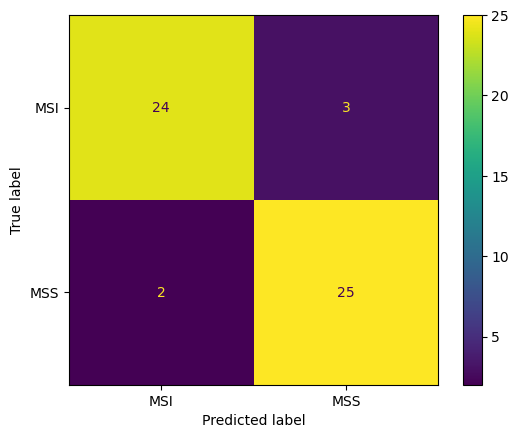

In [35]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)

# Define parameters for XGBoost model
params = {
    'learning_rate':[0.01, 0.1],
    'max_depth': [3, 6, 9],
    'eta': [0.01, 0.1],
    #'lambda': [0.1, 1]
    'alpha': [0.01, 0.1],
    'n_estimators': [20, 50, 100]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate on test set
test_score = grid_search.best_estimator_.score(X_test, y_test)
print("Test Set Accuracy:", test_score)

# Get the predicted labels
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['MSI', 'MSS'])
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
cm_display.plot()#(xticks_rotation=45,ha='right')  # Rotate x-labels by 45 degrees
plt.show()

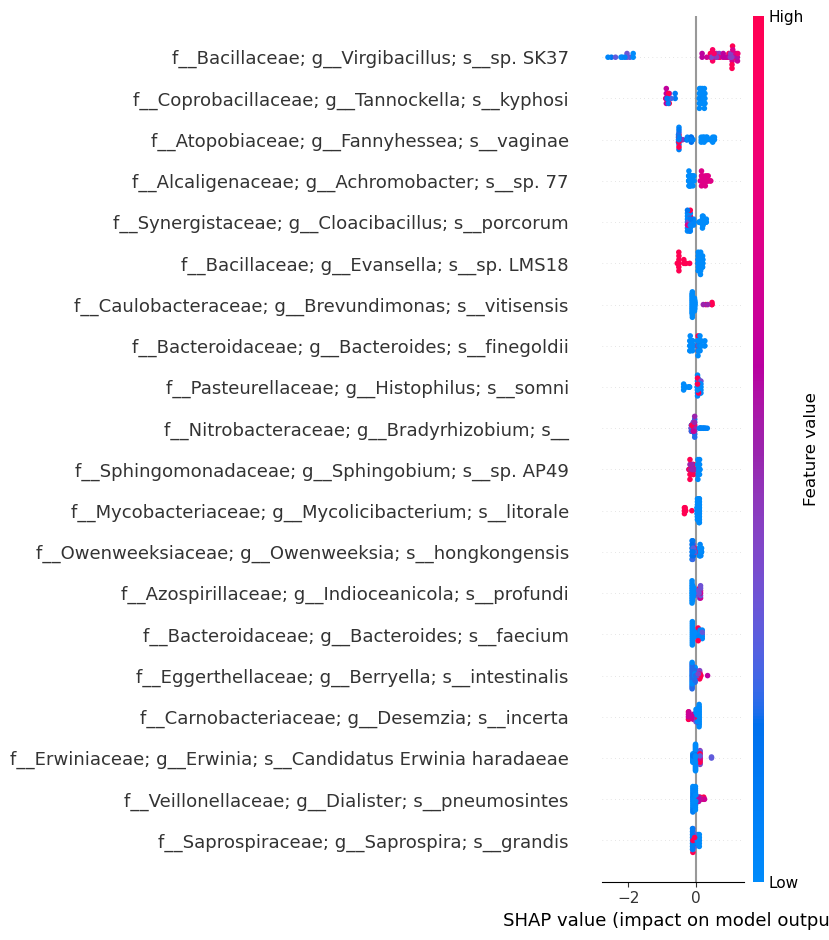

In [36]:
import shap

# Train XGBoost model with best parameters
best_xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', **best_params)
best_xgb_model.fit(X_train, y_train)

# Explain model predictions using SHAP
explainer = shap.Explainer(best_xgb_model)
shap_values = explainer.shap_values(X_test)

# Get feature importance
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)
top_indices = np.argsort(mean_abs_shap_values)[-20:]  # Get indices of top 20 important features

# Subset X_test to include only the top 20 important features
X_test_top_features = X_test[:, top_indices]

# Plot SHAP summary plot for the top 20 important features
shap.summary_plot(shap_values[:, top_indices], X_test_top_features, feature_names=SG_CRC.columns[top_indices], class_names=['MSI', 'MSS'])

# Display the plot
plt.show()


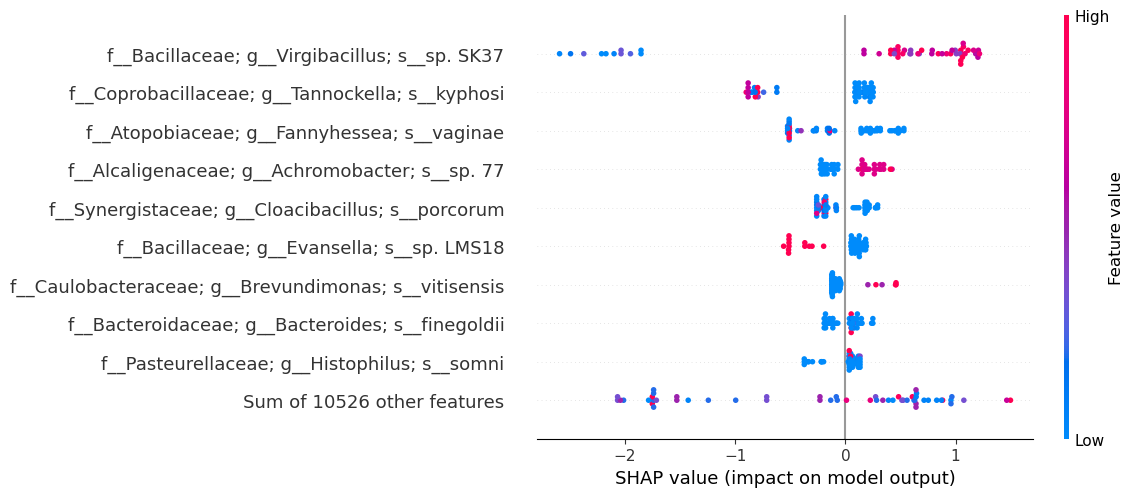

In [53]:
# Train XGBoost model with best parameters
best_xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', **best_params)
best_xgb_model.fit(X_train, y_train)

# Explain model predictions using SHAP
explainer = shap.Explainer(best_xgb_model,feature_names=SG_CRC.columns)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)